In [2]:
%matplotlib inline

In [9]:
import os
import numpy as np
import nibabel as nib
import scipy.stats
from cmath import rect, phase
import matplotlib.pyplot as plt

In [24]:
def mean_angle(rad):
    return (phase(sum(rect(1, d) for d in rad)/float(len(rad))))

In [10]:
img = nib.load('brain.nii')

In [85]:
data = img.get_data()

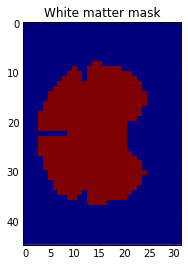

In [86]:
slice = data[:,28,:,0]

# XXX DUMMY SLICE

slice = np.zeros(slice.shape)
xx, yy = np.mgrid[:slice.shape[0], :slice.shape[1]]
x0, y0, radius = 15, 15, 10
circle = (xx - x0)**2 + (yy - y0)**2
slice = circle <= radius**2
slice = 255 * slice.astype(np.uint8)


plt.figure()
plt.imshow(slice, interpolation='none')
plt.title("White matter mask")

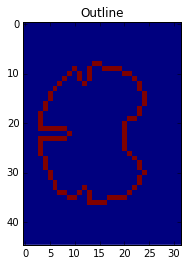

In [87]:
border  = np.zeros_like(slice)
for (i, j), val in np.ndenumerate(slice):
    if i > 0 and i < slice.shape[0] - 1 and j > 0 and j < slice.shape[1] - 1:
        if val > 0:
            if slice[i - 1, j] == 0 \
             or slice[i + 1, j] == 0 \
                or slice[i, j - 1] == 0 \
                or slice[i, j + 1] == 0:
                    border[i, j] = 1
                    
plt.figure()
plt.title("Outline")
plt.imshow(border, interpolation='none')
                

In [88]:
idx = np.where(border)
n_idx = idx[0].size

In [106]:
n_particles = 15000
density = np.zeros_like(slice)
direction = np.nan * np.ones((slice.shape[0], slice.shape[1], n_particles))
direction_new = np.zeros_like(slice, dtype=np.float)

for particle_idx in range(n_particles):
    if particle_idx % 1000 == 0:
        print("Progress: " + str(particle_idx + 1) + " out of " + str(n_particles))
    start_voxel_idx = np.random.randint(n_idx)
    start_voxel = np.array([idx[0][start_voxel_idx], idx[1][start_voxel_idx]], dtype=np.int)
    direction_ang = scipy.stats.uniform(-np.pi, np.pi).rvs()
    direction_vector = np.array([np.cos(direction_ang), np.sin(direction_ang)])

    end_voxel = np.array(start_voxel + direction_vector * slice.shape[0] * slice.shape[1], dtype=np.int)
    
    #
    #   simulate particle trajectory
    #
    
    x0, y0, x1, y1 = start_voxel[0], start_voxel[1], end_voxel[0], end_voxel[1]
    
    steep = 0
    x = x0
    y = y0
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    if (x1 - x) > 0:
        sx = 1
    else:
        sx = -1
    if (y1 - y) > 0:
        sy = 1
    else:
        sy = -1

    if dy > dx:
        steep = 1
        x, y = y, x
        dx, dy = dy, dx
        sx, sy = sy, sx
    d = (2 * dy) - dx

    rr = -1 * np.ones(int(dx) + 1, dtype=np.intp)
    cc = -1 * np.ones(int(dx) + 1, dtype=np.intp)

    for i in range(dx):
        #print("Step"+ str(i))
        if steep:
            rr[i] = x
            cc[i] = y
        else:
            rr[i] = y
            cc[i] = x
        while d >= 0:
            y = y + sy
            d = d - (2 * dx)
        x = x + sx
        d = d + (2 * dy)
        
        if 0 <= cc[i] < slice.shape[0] and 0 <= rr[i] < slice.shape[1]:
            if slice[cc[i], rr[i]] == 0:
                cc[i] = -1
                rr[i] = -1
                break

    rr[dx] = y1
    cc[dx] = x1
    
    #
    #     plot the trajectory
    #
    
    #rr, cc = line(start_voxel[0], start_voxel[1], end_voxel[0], end_voxel[1])
 
    
    for i in range(len(cc)):
        if 0 <= cc[i] < slice.shape[0] and 0 <= rr[i] < slice.shape[1] and not (cc[1] == -1):
            density[cc[i], rr[i]] += 1.
            direction[cc[i], rr[i], particle_idx] = direction_ang
    #dummy *= slice

                     
for i in range(slice.shape[0]):
    for j in range(slice.shape[1]):
        _direction = [direction[i, j, k] for k in range(n_particles) if not np.isnan(direction[i, j, k])]
        if len(_direction) > 0:
            direction_new[i,j] = mean_angle(_direction)
                     
    
                    


Progress: 1 out of 15000
Progress: 1001 out of 15000
Progress: 2001 out of 15000
Progress: 3001 out of 15000
Progress: 4001 out of 15000
Progress: 5001 out of 15000
Progress: 6001 out of 15000
Progress: 7001 out of 15000
Progress: 8001 out of 15000
Progress: 9001 out of 15000
Progress: 10001 out of 15000
Progress: 11001 out of 15000
Progress: 12001 out of 15000
Progress: 13001 out of 15000
Progress: 14001 out of 15000


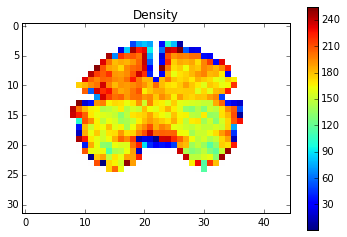

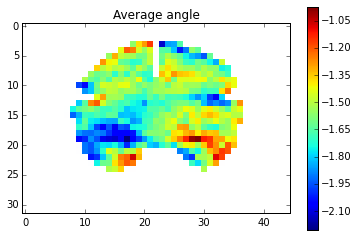

In [109]:
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

plt.figure()
masked_array = np.ma.array(density, mask=255 - slice)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Density")
plt.colorbar()

plt.figure()
masked_array = np.ma.array(direction_new, mask=255 - slice)
plt.imshow(masked_array.T, interpolation='none', cmap=cmap)
plt.title("Average angle")
plt.colorbar()


In [93]:
10000/float(np.sum(slice > 0) )


21.05263157894737